In [1]:
import tensorflow_datasets as tfds
from utils import * 
import cycle_gan
from discriminator import Discriminator
from discriminator_patchGAN import PatchGAN
from generator import *
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

%load_ext autoreload
%autoreload 2
import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
builder = tfds.ImageFolder('datasets/blue2red/')
# print(builder.info)
train_summers = builder.as_dataset(split="trainA", as_supervised=True)
train_winters = builder.as_dataset(split="trainB", as_supervised=True)
test_summers = builder.as_dataset(split="testA", as_supervised=True)
test_winters = builder.as_dataset(split="testB", as_supervised=True)
# tfds.show_examples(ds, builder.info)

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [5]:
train_summers = (
    train_summers.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

train_winters = (
    train_winters.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

test_summers = (
    test_summers.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

test_winters = (
    test_winters.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

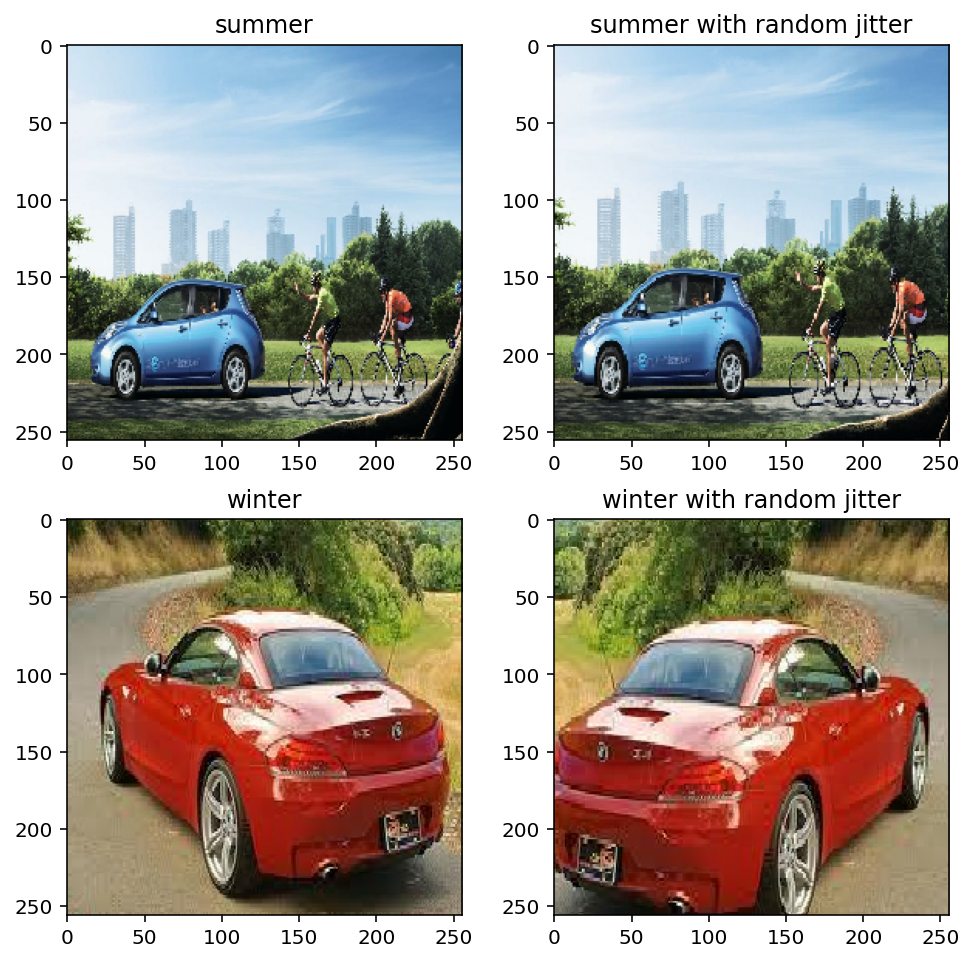

In [6]:
sample_summer = next(iter(train_summers))
sample_winter = next(iter(train_winters))

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('summer')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(222)
plt.title('summer with random jitter')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)

plt.subplot(223)
plt.title('winter')
plt.imshow(sample_winter[0] * 0.5 + 0.5)

plt.subplot(224)
plt.title('winter with random jitter')
plt.imshow(random_jitter(sample_winter[0]) * 0.5 + 0.5)

In [7]:
OUTPUT_CHANNELS = 3
IMG_DIM = getImageSize()
FILTERS = 64  # good results with 32
N_CONV = 2
N_RESBLOCKS = 9

G = Generator(
    filters=FILTERS,
    input_shape=IMG_DIM,
    input_filters=OUTPUT_CHANNELS,
    n_convBlocks=N_CONV,
    n_resBlocks=N_RESBLOCKS,
    n_deconvBlocks=N_CONV,
    name="G",
)
F = Generator(
    filters=FILTERS,
    input_shape=IMG_DIM,
    input_filters=OUTPUT_CHANNELS,
    n_convBlocks=N_CONV,
    n_resBlocks=N_RESBLOCKS,
    n_deconvBlocks=N_CONV,
    name="F",
)

D_x = PatchGAN(FILTERS, IMG_DIM, name="D_x")
D_y = PatchGAN(FILTERS, IMG_DIM, name="D_y")

cyclegan_model = cycle_gan.CycleGAN(G, F, D_x, D_y, paper_generator_loss=True)
cyclegan_model.compile(0.0002, 0.5)

In [ ]:
for j in range(50):
    sample_blue = next(iter(train_summers))
    sample_red = next(iter(train_winters))

    to_red = G(sample_blue)
    to_red_to_blue = F(to_red)
    to_blue = F(sample_red)
    to_blue_to_red = G(to_blue)

    imgs = [
        sample_blue,
        to_red,
        to_red_to_blue,
        sample_red,
        to_blue,
        to_blue_to_red,
    ]
    title = [
        "blue",
        "blue → red",
        "blue → red → blue",
        "red",
        "red → blue",
        "red → blue → red",
    ]
    plt.figure(figsize=(12, 16))
    for i in range(len(imgs)):
        plt.subplot(4, 3, i + 1)
        plt.title(title[i])
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"images/blue2red_{j}", bbox_inches="tight")
    plt.show()

In [47]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    G=G,
    F=F,
    D_x=D_x,
    D_y=D_y,
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [50]:
cyclegan_model.fit(tf.data.Dataset.zip((train_summers, train_winters)), batch_size=1, epochs=50)

Epoch 1/50
619/619 [==============================] - 434s 699ms/step - G_loss: 0.3384 - F_loss: 0.3219 - D_y_loss: 0.2659 - D_x_loss: 0.2651
Epoch 2/50
619/619 [==============================] - 434s 700ms/step - G_loss: 0.3337 - F_loss: 0.3256 - D_y_loss: 0.2625 - D_x_loss: 0.2671
Epoch 3/50
619/619 [==============================] - 434s 700ms/step - G_loss: 0.3327 - F_loss: 0.3491 - D_y_loss: 0.2629 - D_x_loss: 0.2578
Epoch 4/50
619/619 [==============================] - 434s 700ms/step - G_loss: 0.3534 - F_loss: 0.3901 - D_y_loss: 0.2548 - D_x_loss: 0.2498
Epoch 5/50
619/619 [==============================] - 434s 700ms/step - G_loss: 0.3877 - F_loss: 0.4041 - D_y_loss: 0.2449 - D_x_loss: 0.2391
Epoch 6/50
619/619 [==============================] - 434s 700ms/step - G_loss: 0.4116 - F_loss: 0.4028 - D_y_loss: 0.2347 - D_x_loss: 0.2355
Epoch 7/50
619/619 [==============================] - 434s 700ms/step - G_loss: 0.3687 - F_loss: 0.3798 - D_y_loss: 0.2464 - D_x_loss: 0.2414
Epoch 

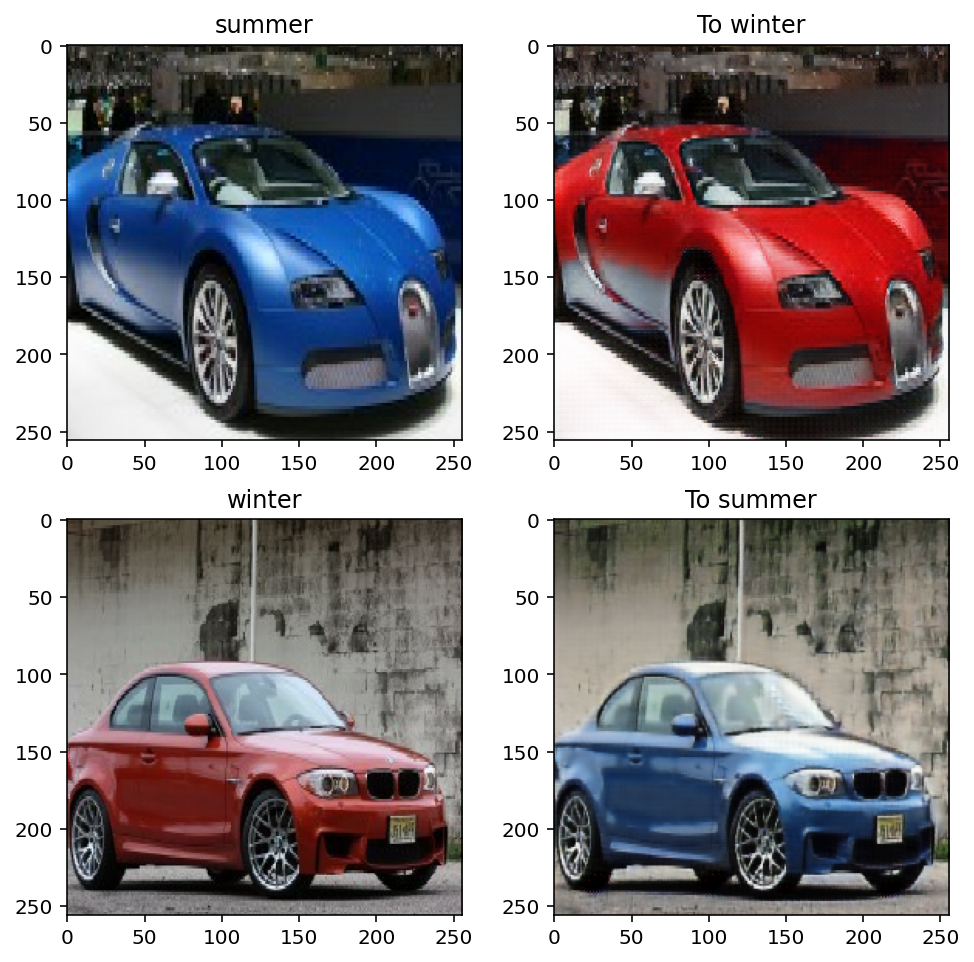

In [51]:
# 2 PatchGAN, 48 features, 256x256, 9 resnetblocks, paper_generator_loss=True
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

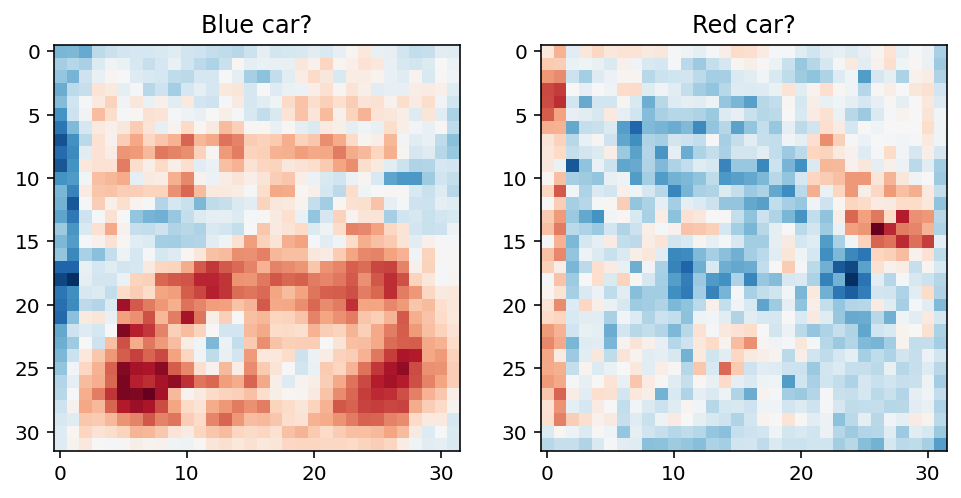

In [102]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Blue car?')
plt.imshow(D_y(sample_red)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Red car?')
plt.imshow(D_x(sample_blue)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [94]:
ckpt_manager.save(5)

'./checkpoints/train/ckpt-5'

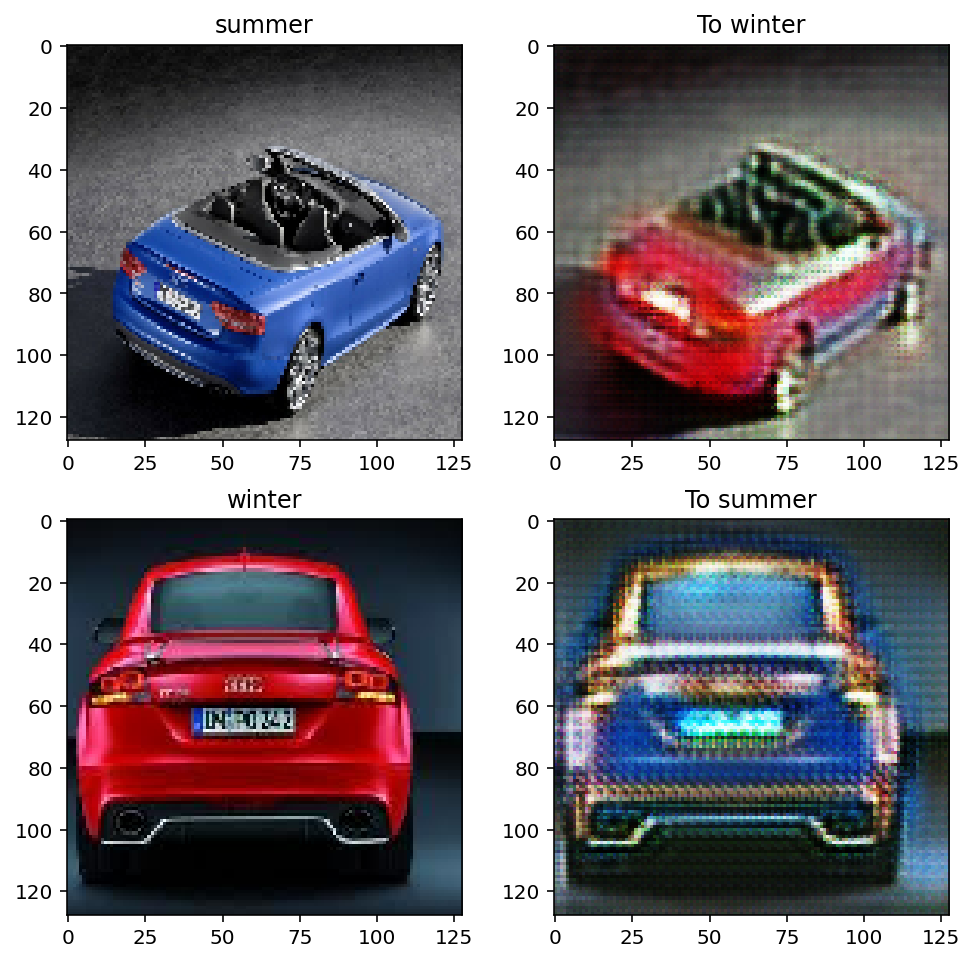

In [21]:
# sample_summer = next(iter(train_summers))
# sample_winter = next(iter(train_winters))

# 2 PatchGANs, 64 features, paper_generator_loss=True
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

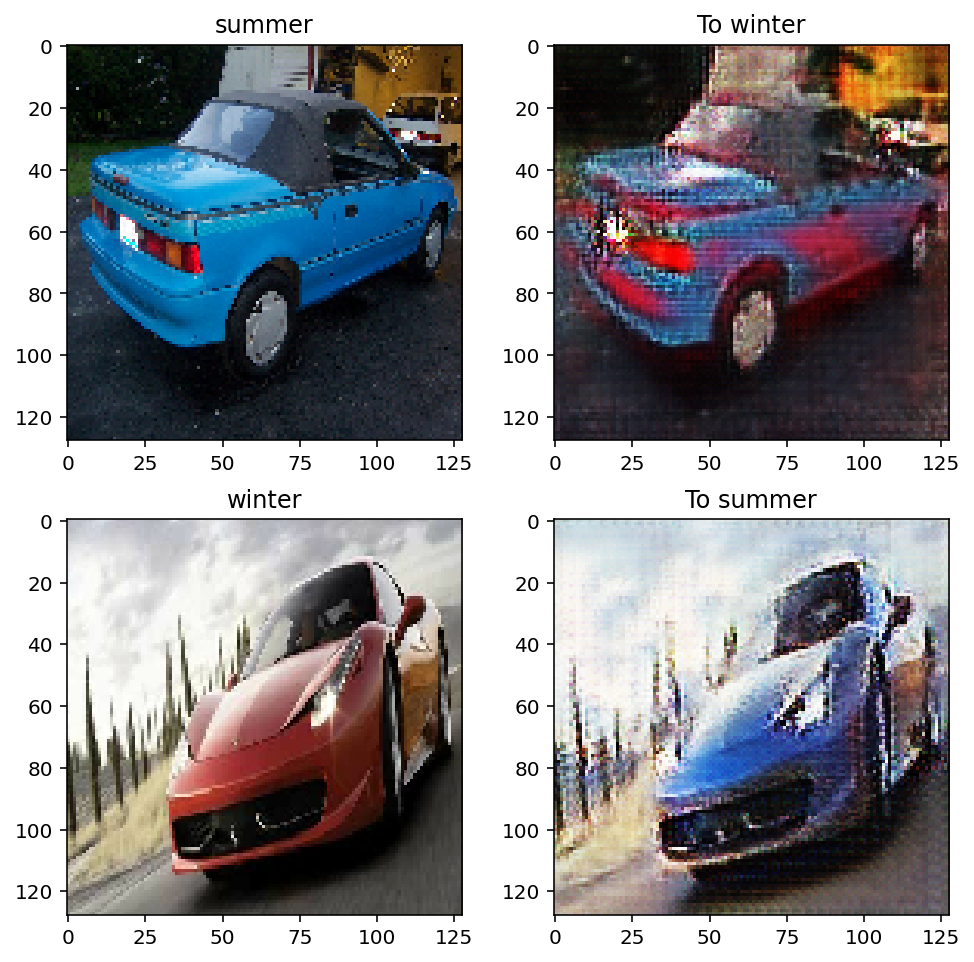

In [32]:
# 2 PatchGANs, 48 features, paper_generator_loss=True
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

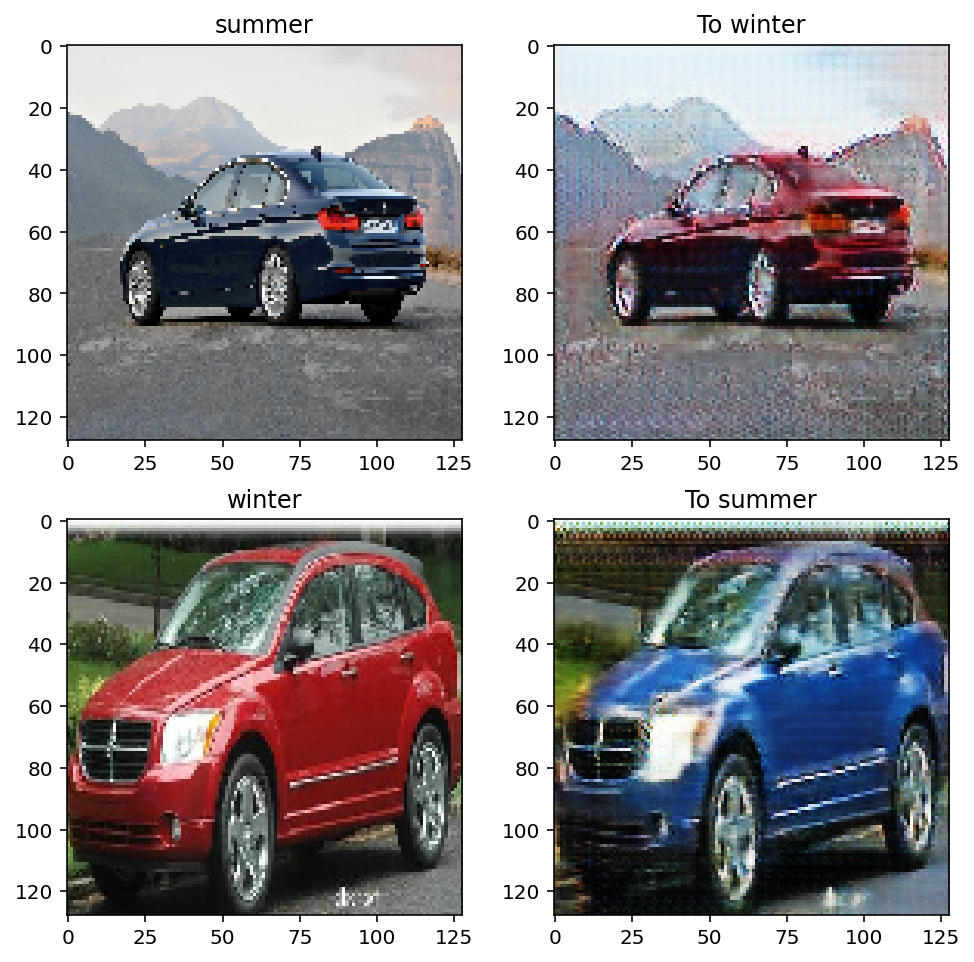

In [17]:
# 2 PatchGANs, 64 features, paper_generator_loss=False, 500 epochs
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

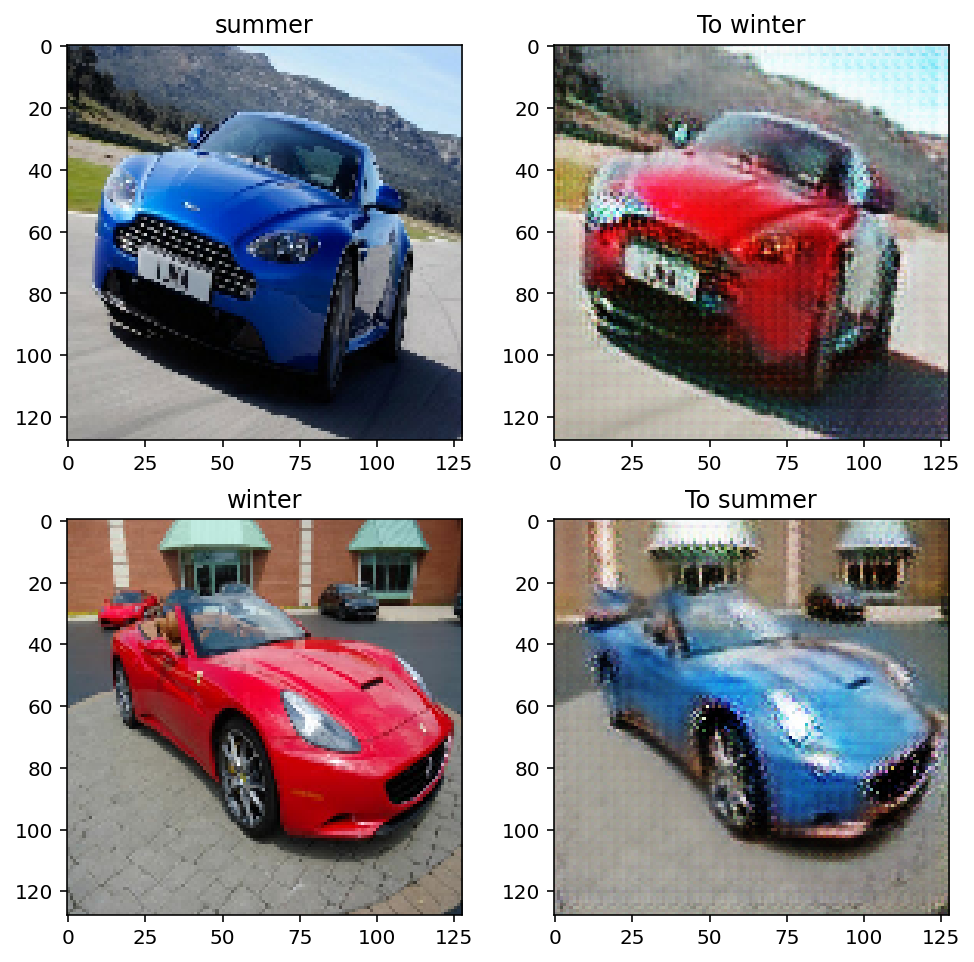

In [25]:
# paper generator loss, 64 features, patchgan
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

In [ ]:
# PatchGAN with 32 initial features/filters

to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

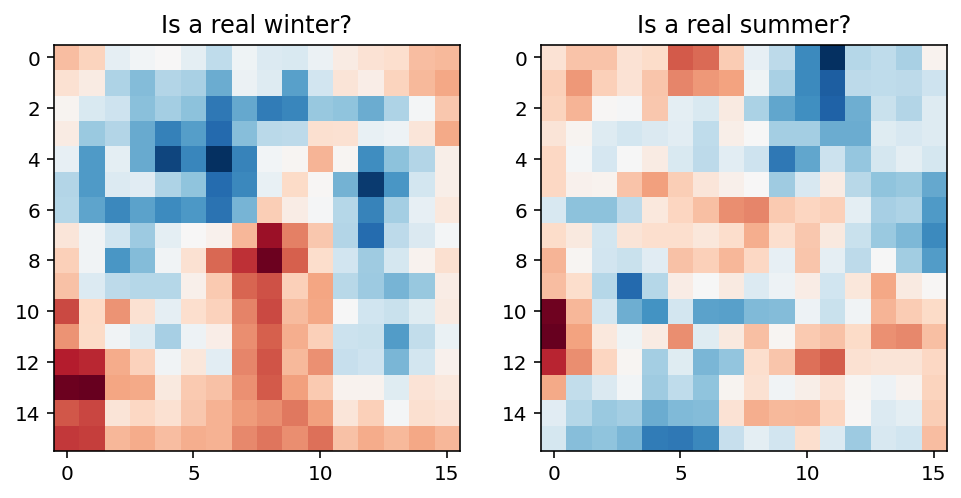

In [37]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real winter?')
plt.imshow(cyclegan_model.D_y(to_winter)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real summer?')
plt.imshow(cyclegan_model.D_x(to_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()

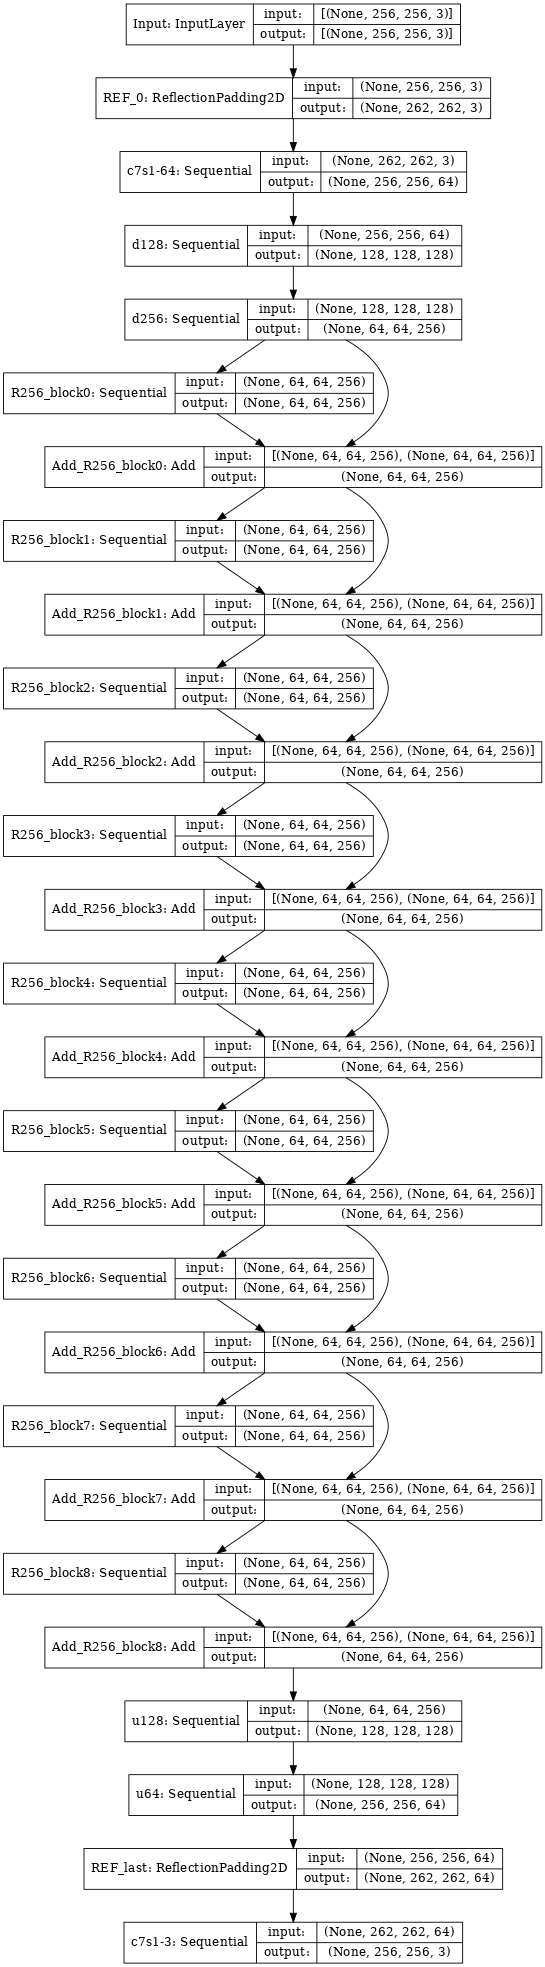

In [8]:
tf.keras.utils.plot_model(
    G, to_file="G.png", show_shapes=True, dpi=64, expand_nested=False
)

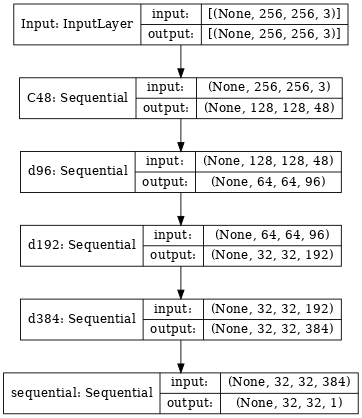

In [15]:
tf.keras.utils.plot_model(
    D_x, to_file="D_x.png", show_shapes=True, dpi=64, expand_nested=False
)

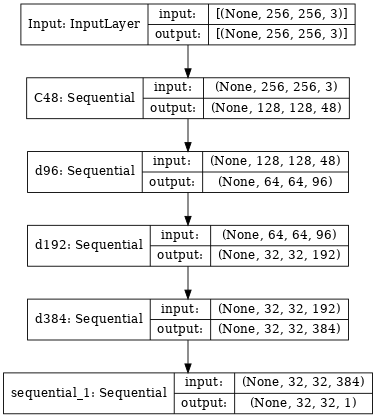

In [16]:
tf.keras.utils.plot_model(
    D_y, to_file="D_y.png", show_shapes=True, dpi=64, expand_nested=False
)